In [ ]:
import scipy.signal
import torch
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import scipy
import numpy as np
# from src.utils.filters import MovingAvg
from src.utils.fourier import sphere2complex, complex2sphere

# def moving_average_freq_response(N, sample_rate, freq):
#     omega = 2 * torch.pi * freq / sample_rate
#     # SMA coefficients
#     b = np.ones(N)
#     a = np.array([N] + [0]*(N-1))

#     # Calculate the frequency response
#     w, h = scipy.signal.freqz(b, a, worN=omega)
#     # w *= sample_rate / (2 * np.pi)                      # Convert from rad/sample to Hz
#     return h

def moving_average_freq_response(N, sample_rate, freq):
    omega = 2 * torch.pi * freq / sample_rate
    coeff = torch.exp(-1j * omega * (N - 1) / 2) / N
    omega = torch.where(omega == 0, 1e-5, omega)
    Hw = coeff * torch.sin(omega * N / 2) / torch.sin(omega / 2)
    # Hw = Hw*torch.exp(1j*omega*N)
    return Hw

# def moving_avg(x, N):
#     avg = torch.nn.AvgPool1d(kernel_size=N, stride=1)
#     front = x[:, 0:1, :].repeat(1, N // 2, 1)
#     end = x[:, -1:, :].repeat(1, N - 1 - N // 2, 1)
#     x = torch.cat([front, x, end], dim=1)
#     x = avg(x.permute(0, 2, 1))
#     x = x.permute(0, 2, 1)
#     return x



original signal

In [ ]:
t = torch.linspace(0, 4*torch.pi, 200)
sample_rate = len(t)/(t.max()-t.min())
x = torch.sin(t) + torch.sin(2*t) + 0.3*torch.sin(12*t) - 10
x_freq = torch.fft.rfft(x)

theta, phi = complex2sphere(x_freq.real, x_freq.imag)

freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()
phase[torch.abs(phase) < 1] = 0
fig, axs = plt.subplots(2)
axs[0].plot(t, x)
axs[1].plot(freq, x_freq.abs())
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
# axs[2].plot(freq, x_freq.angle())
# axs[1].plot(freq, theta)
# axs[2].plot(freq, phi)
fig.tight_layout()



manuplate on the frequency domain

In [ ]:
N = 50
h = moving_average_freq_response(N, sample_rate=sample_rate, freq=freq)
x_freq_new = x_freq * h
# x_freq_new = x_freq * h * torch.exp(torch.tensor(-1j*N))
mag = x_freq_new.abs()
phase = x_freq_new.angle()
x_new = torch.fft.irfft(x_freq_new)
x_new_avgpool = torch.nn.functional.avg_pool1d(x.reshape(1,1,-1), N,N).permute(0,2,1)
fig, axs = plt.subplots(2)
# axs[0].plot(x_new)
axs[0].plot(t, x_new)
# axs[0].scatter(t[N-1::N],x_new[N-1::N])
# axs[0].scatter(t[N-1::N], x_new_avgpool.flatten())
axs[1].plot(freq, mag)
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
# axs[2].plot(freq, phase)

manuplate on the time domain

In [ ]:
from src.utils.filters import MovingAvgTime


x_new = MovingAvgTime(N)(x.reshape(1,-1,1))
# x_new = np.convolve(np.concatenate([x[-N+1:],x]), np.ones(N)/N, mode='valid')
x_freq = torch.fft.rfft(x_new.flatten())
freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()

# mag = x_freq_new.abs()
# phase = x_freq_new.angle()
# # print(phase)
# x = torch.fft.irfft(x_freq_new)
# print(x_new[N//2:-N//2])
fig, axs = plt.subplots(3)
axs[0].plot(x_new.flatten())
axs[1].plot(freq, mag)
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
axs[2].plot(freq, phase)
fig.tight_layout()

In [ ]:
class FreqLinear(torch.nn.Module):
    def __init__(self, in_channels, fft_len, kernal_size) -> None:
        super().__init__()
        self.kernel = torch.nn.Parameter(
            torch.complex(
                torch.ones(fft_len, kernal_size), torch.zeros(fft_len, kernal_size)
            ),
            requires_grad=True,
        )
        self.linear = torch.nn.Linear(kernal_size * in_channels , in_channels).to(torch.cfloat)
        self.in_channels= in_channels
        self.fft_len = fft_len
        
    def forward(self, x):
        # x = x.permute(0,2,1)
        x = torch.fft.rfft(x, norm="ortho", dim=1)
        x_channels = []
        for i in range(x.shape[-1]):
            x_channels.append(x[...,[i]] * self.kernel)
        x = torch.concat(x_channels, dim=-1)
        x = self.linear(x)
        # x = self.linear(x.flatten()).reshape(-1, self.fft_len, self.in_channels)
        x = torch.fft.irfft(x, norm="ortho", dim=1)
        return x


class TimeConv(torch.nn.Module):
    def __init__(self, in_channel) -> None:
        super().__init__()
        self.conv = torch.nn.Conv1d(
            in_channel, out_channels=in_channel, kernel_size=3, bias=False, padding=1
        )

    def forward(self, x):
        # x = x.permute(0,2,1)
        x = self.conv(x)
        return x


x = torch.sin(torch.arange(288) / 100).reshape(1, -1, 2)
m = FreqLinear(in_channels=x.shape[-1], fft_len=x.shape[1]//2+1, kernal_size=10)
for p in m.parameters():
    print(p.numel())
y = torch.ones_like(x)
loss_fn = torch.nn.MSELoss()
loss = loss_fn(y, m(x))
loss.backward()

# x = x.repeat(2,1,1)
# kernel = torch.rand(x.shape[1] // 2 + 1, 3)
# x = torch.fft.rfft(x, dim=1)
# print(x)
# print(kernel)
# print(x.shape)
# print(kernel.shape)
# x * kernel

In [ ]:
import torch
x = torch.ones(100) * 10
# x = torch.randn(1000)
# x = torch.sin(torch.arange(314 * 4) / 100)
x_fft = torch.fft.rfft(x)
plt.plot(x_fft.abs())
plt.yscale("log")
x_fft = x_fft + torch.randn_like(x_fft,dtype=torch.cfloat)
# plt.xscale("log")
plt.plot(x_fft.abs())

fig = plt.figure()
x = torch.fft.irfft(x_fft)
plt.plot(x)

In [ ]:
import torch
def moving_average_1d(data: torch.Tensor, kernel_size:int, stride:int=1):
    # Unfold the data tensor to create a windowed view
    unfolded_data = data.unfold(1, kernel_size, stride)
    print(unfolded_data.shape)
    
    # Create a kernel tensor for matrix multiplication
    kernel = torch.ones(kernel_size) / kernel_size
    
    # Perform matrix multiplication
    moving_averages_unfolded = unfolded_data @ kernel
    
    # # Pad the moving averages tensor to match the original data size
    # padding = kernel_size - 1
    # moving_averages_padded = torch.cat((torch.zeros(padding), moving_averages_unfolded))
    
    # Fold the moving averages tensor to get the final result
    # moving_averages = moving_averages_padded.view(-1)
    
    return moving_averages_unfolded

# Example usage
data = torch.arange(60).float().reshape(2,-1,3)  # 1D tensor with 10 elements
kernel_size = 5

moving_averages = moving_average_1d(data, kernel_size)
print(moving_averages)  # Output: torch.Size([10])

In [ ]:
from src.schedules.collection import linear_schedule
import torch
import matplotlib.pyplot as plt
import pandas as pd
from src.utils.filters import MovingAvgTime, MovingAvgFreq
from src.utils.fourier import complex2sphere, sphere2complex
from scipy.stats import norm

df = pd.read_csv(
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
x = torch.from_numpy(df.values).reshape(1, -1, 1)


# x_norm_fft = torch.fft.rfft(x_norm, dim=1, norm="ortho")
# plt.plot(dct(x, norm='ortho').flatten())
# plt.yscale('log')

# x_norm = (x - x.mean(dim=1)) / torch.sqrt(x.var(dim=1))
freq = torch.fft.rfftfreq(x.shape[1])
print(freq.shape)
# fig, ax = plt.subplots()
# ax.plot(torch.concat([x_fft.real, x_fft.imag[:,1:-1,:]], dim=1).flatten())
# fig.savefig("noisy_0.png")
# plt.close()

mat = [MovingAvgFreq(i, freq=freq).Hw for i in range(2, x.shape[1] + 1)]
mat = torch.concat(mat)
fig, axs = plt.subplots(2)
for i in range(len(freq)):
    axs[0].plot(mat[:,i,:].real)
    axs[1].plot(mat[:,i,:].imag)
    
    
# mat = [MovingAvgTime(i) for i in range(2, x.shape[1] + 1)]
# T = len(mat)
# _, _, alpha_bars = linear_schedule(0, 0, T)
# betas = torch.sqrt(1 - alpha_bars)
# betas

# plt.plot(betas)
# for i, degrade_fn in enumerate(mat):
#     # x_noisy = degrade_fn(x)
#     x_noisy = degrade_fn(x_fft) + torch.randn_like(x_fft) * betas[i]
#     # x_noisy = degrade_fn(x) + torch.randn_like(x) * betas[i]
#     fig, ax = plt.subplots()
#     ax.plot(torch.concat([x_noisy.real, x_noisy.imag[:,1:-1,:]], dim=1).flatten())
#     fig.savefig(f"noisy_{i+1}.png")
#     plt.close()
#     # if i == (T - 1):
#     #     print(norm.fit(x_noisy.numpy().flatten()))

In [ ]:
import torch
import numpy as np
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv(
    "/mnt/ExtraDisk/wcx/research/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
x = torch.from_numpy(df.values).reshape(1, -1, 1)



# Generate a random time-domain signal
N = 1000  # Number of samples

# signal = 2 * torch.sin(torch.linspace(0, 10, 1000))
# signal = torch.randn(N)
# signal = 2 * torch.sin(torch.linspace(0, 10, N))  + torch.randn(N) + 10
signal = x.flatten()
N = len(signal)
print(torch.std(signal, unbiased=False))
signal_norm = (signal - torch.mean(signal)) / torch.std(signal, unbiased=False)
print(signal_norm[:10])
plt.plot(signal)

# Compute the DFT of the signal using PyTorch's rfft function with norm='ortho'
# x_fft = torch.fft.rfft(signal, norm='ortho')
x_fft = dft(signal.reshape(1,-1,1), real_imag=True).flatten()
print(torch.std(x_fft, unbiased=False))
# plt.plot(x_fft * 2**0.5)


# Calculate the mean from the DFT coefficients
mean = x_fft[0].real
mean_minus = torch.concat([mean.reshape(-1,1), torch.zeros(len(x_fft)-1, 1)]).flatten()

# Calculate the variance and standard deviation from the DFT coefficients
energy_freq = torch.sum(torch.abs(x_fft[1:])**2) * 2 # Account for orthogonal normalization and one-sided representation
adjusted_energy = energy_freq
variance = adjusted_energy / (N)
std_dev = torch.sqrt(variance)
signal_fft_norm = (x_fft - mean_minus) / std_dev
# inv_signal_fft_norm = torch.fft.irfft(signal_fft_norm, norm='ortho')
inv_signal_fft_norm = idft(signal_fft_norm.reshape(1, -1, 1), real_imag=True).flatten()
print(inv_signal_fft_norm[:10])
# plt.plot(inv_signal_fft_norm)
(inv_signal_fft_norm - signal_norm).max()


# # Print the results
# print("Mean (Time Domain):", torch.mean(signal).item())
# print("Mean (Frequency Domain):", mean.item())
# print("Standard Deviation (Time Domain):", torch.std(signal).item())
# print("Standard Deviation (Frequency Domain):", std_dev.item())


In [ ]:
import torch
# from src.schedules.collection import linear_schedule, cosine_schedule
from src.utils.filters import MovingAvgFreq, MovingAvgTime
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
x = torch.from_numpy(df.values).reshape(1, -1, 1)
freq = torch.fft.rfftfreq(x.shape[1])
x_freq = torch.fft.rfft(x, dim=1, norm='ortho')


maf = MovingAvgFreq(1, freq=freq)
x_freq_flt = maf(x_freq)
x_freq_flt = torch.fft.irfft(x_freq_flt, dim=1, norm='ortho')[:,0::1,:]
x_time_flt = torch.nn.functional.avg_pool1d(x.permute(0,2,1), 1, 1).permute(0,2,1)
print(x_freq_flt)
print(x_time_flt)
plt.plot(x_freq_flt.flatten())
plt.plot(x_time_flt.flatten())
# mat = [MovingAvgTime(i) for i in range(2, x.shape[1] + 1)]

# for i, degrade_fn in enumerate(mat):
#     # x_noisy = degrade_fn(x)
#     x_noisy = degrade_fn(x_fft) + torch.randn_like(x_fft) * betas[i]
#     # x_noisy = degrade_fn(x) + torch.randn_like(x) * betas[i]
#     fig, ax = plt.subplots()
#     ax.plot(torch.concat([x_noisy.real, x_noisy.imag[:,1:-1,:]], dim=1).flatten())
#     fig.savefig(f"noisy_{i+1}.png")
#     plt.close()
#     # if i == (T - 1):
#     #     print(norm.fit(x_noisy.numpy().flatten()))

In [ ]:
from src.utils.filters import MovingAvgTime, MovingAvgFreq
import torch
import matplotlib.pyplot as plt
import pandas as pd
from src.utils.filters import MovingAvgTime, MovingAvgFreq
from src.utils.fourier import complex2sphere, sphere2complex
from scipy.stats import norm

df = pd.read_csv(
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
mode = "linear"
df = df[:288]
kernel_size = 84
# x = torch.randn(12).reshape(1, -1, 1)
x = torch.from_numpy(df.values).reshape(1, -1, 1)
mat = MovingAvgTime(kernel_size, mode=mode)
x_down_real = mat(x)
mat_stride = torch.nn.AvgPool1d(kernel_size, kernel_size)
x_down_real_stride = mat_stride(x.permute(0, 2, 1))

rec = torch.nn.functional.interpolate(
    x_down_real.reshape(1, 1, 1, -1).repeat(10,1,1,1), size=x.shape[1] - kernel_size + 1, mode=mode
)
real = x_down_real_stride.flatten()
plt.plot(rec[:,0,0,::kernel_size])
plt.plot(real.flatten())


In [ ]:
import torch

a = torch.randn(12).reshape(1, -1, 1).float()
avg = torch.nn.AvgPool1d(3,3)
a_avg = avg(a.permute(0,2,1)).permute(0,2,1)

mean = torch.mean(a, dim=1, keepdim=True)
stdev = torch.sqrt(torch.var(a, dim=1, keepdim=True, unbiased=False) + 1e-5)
a_norm = (a - mean) / stdev
a_norm_avg = avg(a_norm.permute(0,2,1)).permute(0,2,1)
torch.allclose(a_norm_avg*stdev + mean, a_avg)

In [ ]:
import torch
a = torch.arange(16).float()

a_fft_norm = torch.fft.rfft(a, norm='ortho')

k1 = 12
k2 = -2

print(a_fft_norm)
b = k1 * a + k2
print(b)
b_fft = a_fft_norm.clone() 
b_fft = b_fft * k1
b_fft[0] += k2 * len(a) ** 0.5 
print(b_fft)
# print(b_fft)
# print(b)
print(torch.fft.irfft(b_fft, norm='ortho'))
# torch.allclose(4*a, torch.fft.irfft(a_fft * 4))

In [ ]:
import torch
from src.utils.schedule import linear_schedule, cosine_schedule
import matplotlib.pyplot as plt

_,_,_,a = linear_schedule(1e-4, 1e-2, 288)
plt.plot(a)

In [ ]:
import torch

ks = 100
# a = torch.sin(torch.linspace(0, torch.pi * 2, 1000)).float()
# a = a + torch.randn_like(a) * 0.1
a = torch.arange(100000).float()
a_std, a_mean = torch.std_mean(a)
print(a_std, a_mean)
a = torch.nn.functional.avg_pool1d(a.reshape(1, 1, -1), ks, 1).flatten()
a_std, a_mean = torch.std_mean(a)
print(a_std, a_mean)

In [ ]:
import torch
import matplotlib.pyplot as plt

N = 1000
a = torch.sin(torch.linspace(0, 100, N)) + torch.exp(torch.linspace(0, 100, N) / 50)

plt.plot(a)
a_fft = torch.fft.rfft(a)
print(a_fft[0])
# plt.plot(a_fft.real)
# plt.plot(a_fft.imag)
noise = torch.randn(N)
a = a + noise
plt.plot(a)
a_fft = torch.fft.rfft(a)
print(a_fft[0])
print(torch.fft.rfft(noise)[0])
# plt.plot(a_fft.real)
# plt.plot(a_fft.imag)

In [3]:
import pandas as pd

df_freq = pd.read_csv('../assets/MADFreq_fast_dtm.csv', index_col=0)
df_time = pd.read_csv('../assets/MADTime_fast_dtm.csv', index_col=0)
df = pd.concat([df_freq, df_time])
df = df.reset_index(drop=True)
# df[df['method']=='MLPBackbone_freq_norm_True_diff_True_empirical']
df[df['granularity']==1].sort_values('MPBL')


,method,granularity,RMSE,MAE,CRPS,MPBL
593,MLPBackbone_time_norm_True_diff_False_empirical,1,0.033059,0.024276,0.024792,0.010953
161,MLPBackbone_freq_norm_True_diff_False_empirical,1,0.033490,0.024833,0.025208,0.011175
647,MLPBackbone_time_norm_True_diff_True_empirical,1,0.032865,0.024394,0.025447,0.011276
215,MLPBackbone_freq_norm_True_diff_True_empirical,1,0.032315,0.024193,0.025686,0.011372
809,ResNetBackbone_time_norm_True_diff_False_empir...,1,0.032981,0.024398,0.025966,0.011520
557,MLPBackbone_time_norm_True_diff_False_cosine,1,0.034265,0.025188,0.025952,0.011522
629,MLPBackbone_time_norm_True_diff_True_ddpm,1,0.033122,0.024632,0.025994,0.011527
575,MLPBackbone_time_norm_True_diff_False_ddpm,1,0.034225,0.025075,0.026053,0.011569
143,MLPBackbone_freq_norm_True_diff_False_ddpm,1,0.035113,0.025812,0.026310,0.011724
611,MLPBackbone_time_norm_True_diff_True_cosine,1,0.034036,0.025299,0.026338,0.011725


In [1]:
import pandas as pd

df = pd.read_csv('../assets/fast_dtm.csv', index_col=0)
df[df['granularity']==1].sort_values('RMSE')


,method,granularity,RMSE,MAE,CRPS
17,ResNetBackbone_time_norm_True_diff_False_hot,1,0.033893,0.025070,0.030144
17,MLPBackbone_time_norm_True_diff_True_hot,1,0.034666,0.025792,0.030451
17,MLPBackbone_time_norm_True_diff_False_hot,1,0.034819,0.025304,0.030212
17,ResNetBackbone_time_norm_True_diff_True_hot,1,0.034930,0.026124,0.030741
17,MLPBackbone_time_norm_False_diff_True_hot,1,0.059674,0.044597,0.048167
17,MLPBackbone_time_norm_False_diff_False_hot,1,0.060622,0.043641,0.047485
17,ResNetBackbone_time_norm_False_diff_True_hot,1,0.072721,0.053818,0.056717
17,ResNetBackbone_time_norm_False_diff_False_hot,1,0.077688,0.055433,0.058517


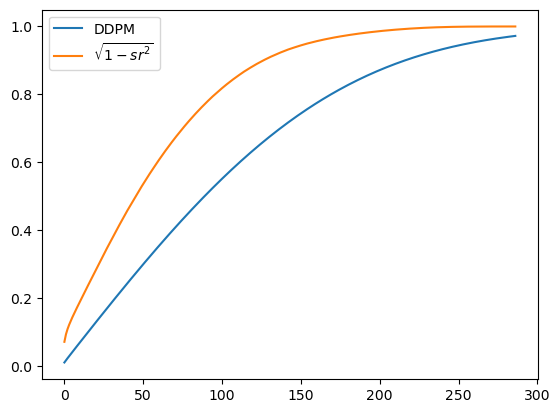

In [1]:
import torch
import matplotlib.pyplot as plt
from src.utils.schedule import linear_schedule, cosine_schedule

var_schedule = torch.load("/home/user/data/FrequencyDiffusion/savings/std_schedule.pt")
# print(var_schedule)
var_schedule = torch.sqrt(1 - var_schedule**2)
# torch.save(torch.sqrt(1 - var_schedule**2), "/home/user/data/FrequencyDiffusion/savings/empirical_schedule.pt")
betas = linear_schedule(1e-4, 2e-2, len(var_schedule))[-1]
plt.plot(betas, label="DDPM")
# torch.save(betas, "/home/user/data/FrequencyDiffusion/savings/ddpm_schedule.pt")
betas = cosine_schedule(len(var_schedule))[-1]
# torch.save(betas, "/home/user/data/FrequencyDiffusion/savings/cosine_schedule.pt")

# plt.plot(var_schedule, label='std_ratio')
# plt.plot(1 - var_schedule, label="1-sr")
# plt.plot(torch.sqrt(1 - var_schedule), label="$\sqrt{1-sr}$")
plt.plot(var_schedule, label="$\sqrt{1-sr^2}$")
# plt.plot(betas, label="cosine")
plt.legend()

In [34]:
import numpy as np
from sklearn.metrics import mean_pinball_loss


def mpbl(y_pred, y_real, quantiles=[2.5 * (1 + i) for i in range(39)]):
    y_pred_q = np.quantile(y_pred, quantiles, axis=0)
    quantiles = np.array(quantiles).reshape(-1, *[1 for _ in range(y_pred_q.ndim - 1)])
    error = y_real - y_pred_q  # * n*9
    first_term = quantiles * error
    second_term = (quantiles - 1) * error
    loss = np.maximum(first_term, second_term)
    return loss.mean()


y_pred = np.random.rand(100, 2, 1)
y_true = np.random.rand(2, 1)
q = [0.1 * (1 + i) for i in range(9)]
y_pred_q = np.quantile(y_pred, q, axis=0)
print(y_pred_q)
print(mpbl(y_pred, y_true, quantiles=q))

all_pbl = 0
for i, qq in enumerate(q):
    pbl = mean_pinball_loss(
        y_true.flatten(), y_pred_q[i].flatten(), alpha=qq, multioutput="raw_values"
    )
    all_pbl += pbl
all_pbl / len(q)

[[[0.1761785 ]
  [0.04889425]]

 [[0.25139701]
  [0.14538174]]

 [[0.39018921]
  [0.24237439]]

 [[0.5051796 ]
  [0.30825067]]

 [[0.55572393]
  [0.42115212]]

 [[0.6298693 ]
  [0.50262557]]

 [[0.74226855]
  [0.64699951]]

 [[0.79802372]
  [0.75596753]]

 [[0.90112633]
  [0.90913251]]]
0.12395325102358884


array([0.12395325])